In [112]:
import h5py
import numpy as np
import pandas as pd
import cv2

In [113]:
import os
import rasterio as rio 
from osgeo import gdal
import matplotlib.pyplot as plt
from PIL import Image

In [ ]:
# reading in data directly from h5 file, indexing using numpy 
f = h5py.File('../data/raw/pollution_data.h5', 'r')
list(f.keys())

pollution_data = np.array(f.get("SCIENCE_DATA/UVAerosolIndex354and388"))
lat = np.array(f.get("GEOLOCATION_DATA/Latitude"))
long = np.array(f.get("GEOLOCATION_DATA/Longitude"))

pol_data = pollution_data.flatten()
lat_idx = lat.flatten()
long_idx = long.flatten()

pol_data = pol_data[(lat_idx <= -10) & (lat_idx >= -20) & (long_idx <= -50) & (long_idx >= -60)]
pol_data 

# interpolation using cv2 

data = pol_data
colname = "pollution_data"
grid_size = 500

grid = cv2.resize(data, dsize=(grid_size, grid_size), interpolation = cv2.INTER_AREA)

# create dataframe 
row = np.arange(grid_size ** 2) // grid_size
col = np.arange(grid_size ** 2) % grid_size

h5_df = pd.DataFrame(index = row * grid_size + col)
h5_df["row"] = row
h5_df["col"] = col

h5_df[colname] = grid.flatten()
#h5_df.to_csv("../data/processed/pollution_h5.csv", index_label = "id")

# reading in data from csv files downloaded from panoply, indexing as pandas dataframe 

p = pd.read_csv("../data/raw/UVAerosolIndex354and388.csv", header = None)
lat = pd.read_csv("../data/raw/Latitude.csv", header = None)
long = pd.read_csv("../data/raw/Longitude.csv", header = None)

row = np.tile(np.arange(0, 1643), 60)
col = np.repeat(np.arange(0, 60), 1643)

pol_df = pd.DataFrame(index = np.arange(0, 98580))
pol_df["row"] = row
pol_df["col"] = col

pol_df["lat"] = np.array(lat).flatten()
pol_df["long"] = np.array(long).flatten()
pol_df["pollution"] = np.array(p).flatten()

# interpolation using cv2 
data = np.array(pol_df["pollution"])
colname = "pollution_data"
grid_size = 500

grid = cv2.resize(data, dsize=(grid_size, grid_size), interpolation = cv2.INTER_AREA)

# create dataframe 
row = np.arange(grid_size ** 2) // grid_size
col = np.arange(grid_size ** 2) % grid_size

pd_df = pd.DataFrame(index = row * grid_size + col)
pd_df["row"] = row
pd_df["col"] = col

pd_df[colname] = grid.flatten()
#pol_df.to_csv("../data/processed/pollution_pd.csv", index_label = "id")

# pd_df["pollution_data"].describe()
# h5_df["pollution_data"].describe()

In [3]:
# gdal_translate -a_srs '+proj=longlat +datum=WGS84 +no_defs' -a_ullr 89.885323 180 -89.728508 180 
# HDF5:"OMI-Aura_L2-OMIAuraAER_2005m0922t160611-o06326_v01-00-2018m0910t134218.h5"://SCIENCE_DATA/UVAerosolIndex354and388 uvai.tif

# f = h5py.File("../data/raw/UVAI_data_2005/OMI-Aura_L2-OMIAuraAER_2005m0922t160611-o06326_v01-00-2018m0910t134218.h5", 'r')
# gdal.Translate("test.tif", "OMI-Aura_L2-OMIAuraAER_2005m0922t160611-o06326_v01-00-2018m0910t134218.h5"://SCIENCE_DATA/UVAerosolIndex354and388, outputSRS = '+proj=longlat +datum=WGS84 +no_defs', outputBounds = [89.885323, 180, -89.728508, 180])

In [ ]:
# shitty code that i don't care about
# sum arrays
na_val = -1.2676506e+30
na_count = np.full((1643, 60), len(uvai))

uv_43 = np.zeros((1643, 60))
troublemakers = []

# sum arrays w/shape 1644/1643
for arr in uvai:
    if arr.shape == (1644, 60):
        arr = arr[0:1643]
      
    na_idx = np.where(arr == na_val)
    na_count[na_idx] -= 1
    arr[na_idx] = 0
   
    if arr.shape == (1643, 60):
        uv_43 = np.add(uv_43, arr)
    else:
        troublemakers.append(arr)

# sum arrays with varying shapes 
tr_sum = np.zeros((1643, 60))
for arr in troublemakers:
    new = np.zeros((1643, 60))
    for i in range(len(new)):
        if i < len(arr):
            new[i] = arr[i]
        else:
            new[i] = np.repeat(0, 60)
            na_count[i] -= 1
        tr_sum = np.add(new, tr_sum)
    
# sum all arrays together

uvai_2005 = np.add(uv_43, tr_sum)

# take mean and set NA values 
real_idx = np.where(uvai_2005 != 0)
uvai_2005[real_idx] = uvai_2005[real_idx]/na_count[real_idx]
uvai_2005[np.where(uvai_2005 == 0)] = na_val
uvai_2005.shape

In [185]:
path = "../data/raw/UVAI_data_2005/OMI-Aura_L2-OMIAuraAER_2005m0101t164929-o02482_v01-00-2018m0910t100043.h5"
f = h5py.File(path, 'r')

lat_2d = np.array(f.get("GEOLOCATION_DATA/Latitude"))
long_2d = np.array(f.get("GEOLOCATION_DATA/Longitude"))

uvai = []
with os.scandir("../data/raw/UVAI_data_2005") as entries:
    for entry in entries:
        if entry.is_file() and entry.name.endswith("tif"):
            with rio.open(entry.path) as src:
                data = src.read()
                data = np.squeeze(data).astype("float32")
                uvai.append(data.flatten())


In [199]:
# sum arrays
na_val = -1.2676506e+30
n = len(uvai[0])
na_count = np.full((n,), len(uvai))

uv = np.zeros((n,))

for data in uvai:
    if len(data) != n:
        diff = n - len(data)
        data = np.concatenate([data, np.repeat(na_val, diff)])
        na_idx = np.where(data == na_val)[0]
        na_count[na_idx] -= 1
        data[na_idx] = 0
        
    uv = np.add(uv, data)

real_idx = np.where(uv != 0)[0]

uv[real_idx] = uv[real_idx]/na_count[real_idx]
uv[np.where(uv == 0)[0]] = na_val

[-1.2676506e+30 -1.2676506e+30 -1.2676506e+30 ... -1.2676506e+30
 -1.2676506e+30 -1.2676506e+30]


False

In [202]:
LAT_MAX, LONG_MIN = (-10, -60)
LAT_MIN, LONG_MAX = (-20, -50)

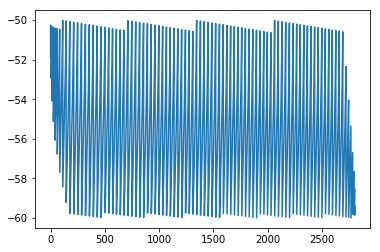

In [143]:
uv = uvai_2005.flatten()
lat = lat_2d.flatten()
long = long_2d.flatten()

#print(uv)
idx = np.where((lat >= LAT_MIN) & (lat <= LAT_MAX) & (long <= LONG_MAX) & (long >= LONG_MIN))[0]

lat = lat[idx]
long = long[idx]

#plt.plot(long)
plt.plot(long)

#plt.scatter(lat, long)

In [146]:
# make into 1d-arrays 
uv = uvai_2005.flatten()
lat = lat_2d.flatten()
long = long_2d.flatten()

print(min(uv[uv != na_val]), max(uv), 
      np.median(uv[uv != na_val]), 
      np.mean(uv[uv != na_val]), 
      np.std(uv[uv != na_val]))

# filter values by given area 
idx = np.where((lat >= LAT_MIN) & (lat <= LAT_MAX) & (long <= LONG_MAX) & (long >= LONG_MIN))[0]

lat = lat[idx]
long = long[idx]
uv = uv[idx]

dataset = pd.DataFrame({'lat': lat, 'long': long, 'uv': uv})
dataset

-109.05576240253009 228.2711404401947 9.194387430500651 12.813864399409274 18.013110542360238


,lat,long,uv
0,-19.957968,-50.268730,14.553036
1,-19.996403,-51.928429,13.291637
2,-19.960110,-51.562523,9.232484
3,-19.922138,-51.172310,10.270955
4,-19.881969,-50.753712,13.042572
...,...,...,...
2798,-10.047875,-58.755051,-1.462653
2799,-10.016959,-58.541637,1.561423
2800,-10.091998,-59.855450,-6.387678
2801,-10.057291,-59.637646,-3.755314


In [138]:
print(uv[0:3], uv[2800:2803])
# arrays are of length 2803, make arrays fit to length 2809 to make grids 
latx = np.linspace(LAT_MAX, LAT_MIN, 53).flatten()
longy = np.linspace(LONG_MAX, LONG_MIN, 53).flatten()

na_lat = np.random.choice(latx, 6)
na_long = np.random.choice(longy, 6)

lat = np.concatenate([lat, na_lat])
long = np.concatenate([long, na_long])
uv = np.concatenate([np.repeat(na_val, 3), uv, np.repeat(na_val, 3)])

# options to f
# for x in na_lat[0:3]:
#     val = uv[np.where(lat == x)] 
#     uv = np.append(uv, val)
#     uv[np.where(lat == x)] = na_val

# for y in na_long[0:3]:
#     val = uv[np.where(long == y)] 
#     uv = np.append(uv, val)
#     uv[np.where(long == y)] = na_val

-109.05576240253009 228.2711404401947 9.194387430500651 12.813864399409274 18.013110542360238
[14.55303572 13.29163741  9.23248418] [-6.38767803 -3.75531441 -8.03705299]


In [120]:
# seg_img = Image.fromarray(uv)
# path = "../data/UVAI_05_10S60W.tif" 
# seg_img.save(path)

In [121]:
def grid_data(data, colname, grid_size, smaller):
        
    if smaller:
        grid = cv2.resize(data, dsize=(grid_size, grid_size), interpolation = cv2.INTER_LINEAR)
    else:
        grid = cv2.resize(data, dsize=(grid_size, grid_size), interpolation = cv2.INTER_AREA)

    row = np.arange(grid_size ** 2) // grid_size
    col = np.arange(grid_size ** 2) % grid_size
    
    df = pd.DataFrame(index = row * grid_size + col)
    df["row"] = row
    df["col"] = col
    
    df[colname] = grid.flatten()
    
    return df

In [122]:
uv_grid = np.reshape(uv, (53, 53))
uv_df = grid_data(uv_grid, "UVAI_05", grid_size=500, smaller=False)

In [131]:
uv_df
uv_df.describe()

,row,col,UVAI_05
count,250000.000000,250000.000000,2.500000e+05
mean,249.500000,249.500000,-2.707691e+27
std,144.337567,144.337567,5.763321e+28
min,0.000000,0.000000,-1.267651e+30
25%,124.750000,124.750000,-1.971135e+00
50%,249.500000,249.500000,7.352476e+00
75%,374.250000,374.250000,1.230183e+01
max,499.000000,499.000000,2.630485e+01


In [ ]:
# gdal for conversion to raster ? 
# https://gdal.org/python/index.html
# https://gis.stackexchange.com/questions/154669/editing-tiff-rasters-in-python
# https://stackoverflow.com/questions/37648439/simplest-way-to-save-array-into-raster-file-in-python
# https://gis.stackexchange.com/questions/325155/transforming-a-image-to-a-shape-defined-by-image-corners-in-earth-coordinates
# https://gdal.org/tutorials/raster_api_tut.html#using-create
# https://gis.stackexchange.com/questions/168877/how-to-set-the-geotransform-using-gdal-in-python

path = '../data/raw/uvai_2005.tif'
xsize = len(uvai_2005)
ysize = len(uvai_2005[0])

driver = gdal.GetDriverByName('GTiff')
new_tiff = driver.Create(path,xsize,ysize,1,gdal.GDT_Float32)
new_tiff.SetGeoTransform(geotransform)
new_tiff.SetProjection(projection)
new_tiff.GetRasterBand(1).WriteArray(array)
new_tiff.FlushCache() #Saves to disk 
new_tiff = None #closes the file

from osgeo import osr
import numpy
new_tiff.SetGeoTransform([444720, 30, 0, 3751320, 0, -30])
srs = osr.SpatialReference()
srs.SetUTM(11, 1)
srs.SetWellKnownGeogCS("NAD27")
dst_ds.SetProjection(srs.ExportToWkt())
raster = numpy.zeros((512, 512), dtype=numpy.uint8)
dst_ds.GetRasterBand(1).WriteArray(raster)
# Once we're done, close properly the dataset
dst_ds = None

In [ ]:
# lat and long values change for each dataset 
# keep track of actual values vs. na values to get accurate mean 